In [1]:
import numpy as np
from numpy.random import RandomState
np.random.seed(1)

from tsne import bh_sne

import matplotlib.pyplot as plt

import os
import os.path
import glob

from keras.preprocessing import image
from keras.applications.xception import Xception,preprocess_input

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Creating base_model (Xception notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = Xception(weights='imagenet', input_shape=image_shape, include_top=False)

In [6]:
filename = 'malimg-xceptionfeatures.npy'
if os.path.exists(filename):
    print("Loading Xception extracted features from %s ..." %(filename))
    xceptionfeatures = np.load(filename)
else:
    print("Extracting features from Xception layers ...")
    xceptionfeatures = base_model.predict(X)
    print("Saving Xception extracted features into %s ..." %(filename))
    np.save(filename, xceptionfeatures)

Extracting features from Xception layers ...
Saving Xception extracted features into malimg-xceptionfeatures.npy ...


In [7]:
xceptionfeatures.shape

(9339, 7, 7, 2048)

In [8]:
xceptionfeatures = np.reshape(xceptionfeatures,(xceptionfeatures.shape[0],-1))

In [9]:
xceptionfeatures.shape

(9339, 100352)

In [10]:
print("Running t-SNE ...")
vis_data = bh_sne(np.float64(xceptionfeatures), d=2, perplexity=30., theta=0.5, random_state=RandomState(1))

Running t-SNE ...


Plotting t-SNE ...


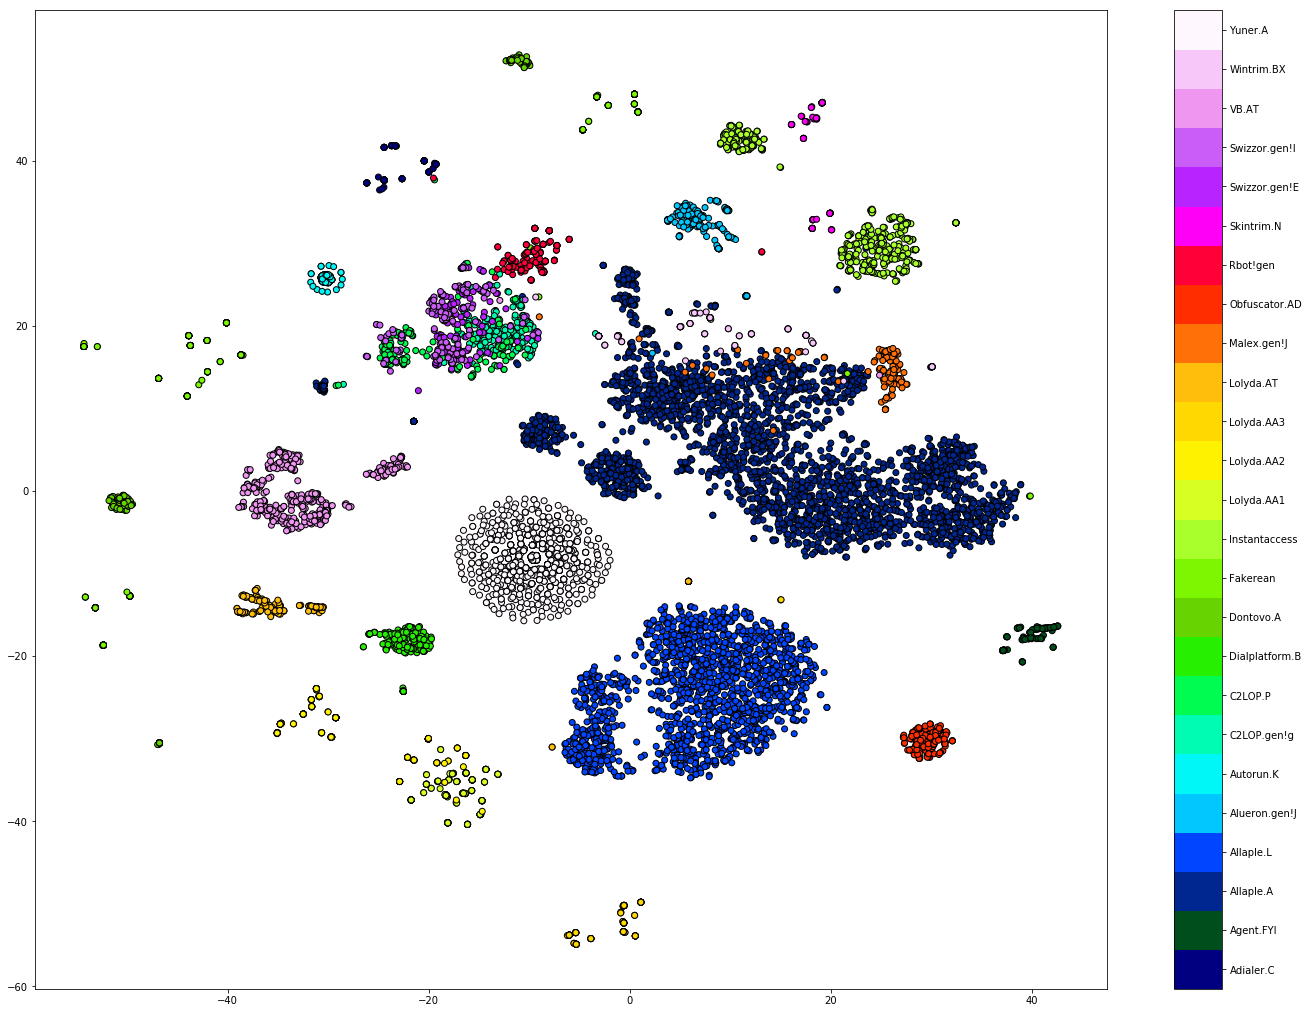

In [11]:
print("Plotting t-SNE ...")
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.scatter(vis_data[:, 0], vis_data[:, 1], c=y, cmap=plt.cm.get_cmap("gist_ncar", len(list_fams)),edgecolors="black")
plt.clim(-0.5, len(list_fams)-0.5)
cbar = plt.colorbar(ticks=range(len(list_fams)))
cbar.ax.set_yticklabels(list_fams)                     
plt.show()